In [1]:
# %%
from napatrackmater.Trackvector import TrackVector
from pathlib import Path 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from napatrackmater.Trackvector import (SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        populate_zero_gen_tracklets, 
                                        get_zero_gen_daughter_generations,
                                        populate_daughter_tracklets,
                                        plot_at_mitosis_time, 
                                        plot_histograms_for_groups,
                                        create_video,
                                        normalize_list
                                        )
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


/home/debian/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-09-15 20:47:45.189697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 20:47:45.225319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 20:47:45.236309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 20:47:45.273279: I tensorflow/core/platform/cpu_feature

In [2]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'

master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))
oneat_detections = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/oneat_detections/non_maximal_oneat_mitosis_locations_{channel}timelapse_{dataset_name.lower()}_dataset.csv'


save_dir = os.path.join(tracking_directory, f'distribution_plots/')
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

Path(save_dir).mkdir(exist_ok=True, parents=True) 
Path(data_frames_dir).mkdir(exist_ok=True, parents=True) 

save_file_normalized = os.path.join(data_frames_dir , f'results_dataframe_normalized_{channel}.csv')
save_file_unnormalized = os.path.join(data_frames_dir , f'results_dataframe_{channel}.csv')  
save_file = os.path.join(data_frames_dir , f'results_dataframe_{channel}.csv')   

block_size = 100
overlap = 50
plot_at_mitosis_time_distribution = False
verbose_generation_plots = False
shape_cols = SHAPE_FEATURES
dynamic_cols = DYNAMIC_FEATURES
feature_cols = SHAPE_DYNAMIC_FEATURES



In [3]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.oneat_csv_file = oneat_detections
track_vectors.oneat_threshold_cutoff = 0.9999
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax
if plot_at_mitosis_time_distribution:
  track_vectors._interactive_function()

if os.path.exists(save_file_unnormalized):
    print(f'reading data from {save_file_unnormalized}')
    global_shape_dynamic_dataframe = pd.read_csv(save_file_unnormalized)
    
else:    
    print('no saved un-normalized dataframe found, computing ...')
    track_vectors._interactive_function()
    global_shape_dynamic_dataframe = track_vectors.get_shape_dynamic_feature_dataframe()
    copy_dataframe = global_shape_dynamic_dataframe.copy(deep = True)
    global_shape_dynamic_dataframe.to_csv(save_file_unnormalized)
if os.path.exists(save_file_normalized):
    print(f'reading data from {save_file_normalized}')      
    normalized_global_shape_dynamic_dataframe = pd.read_csv(save_file_normalized)
else:
    normalized_global_shape_dynamic_dataframe = copy_dataframe    
    for col in feature_cols:
                 normalized_global_shape_dynamic_dataframe[col] = normalize_list(copy_dataframe[col])
    normalized_global_shape_dynamic_dataframe.to_csv(save_file_normalized)

Reading Master XML
no saved un-normalized dataframe found, computing ...
Iterating over spots in frame
Iterating over tracks 2178
Improving mitosis track classification using Oneat
getting attributes
returning shape and dynamic vectors as list 3176


In [4]:

if not os.path.exists(save_file_unnormalized):
    global_shape_dynamic_dataframe.to_csv(save_file_unnormalized)

if not os.path.exists(save_file_normalized):
    normalized_global_shape_dynamic_dataframe.to_csv(save_file_normalized)

### Mitosis count vs time 

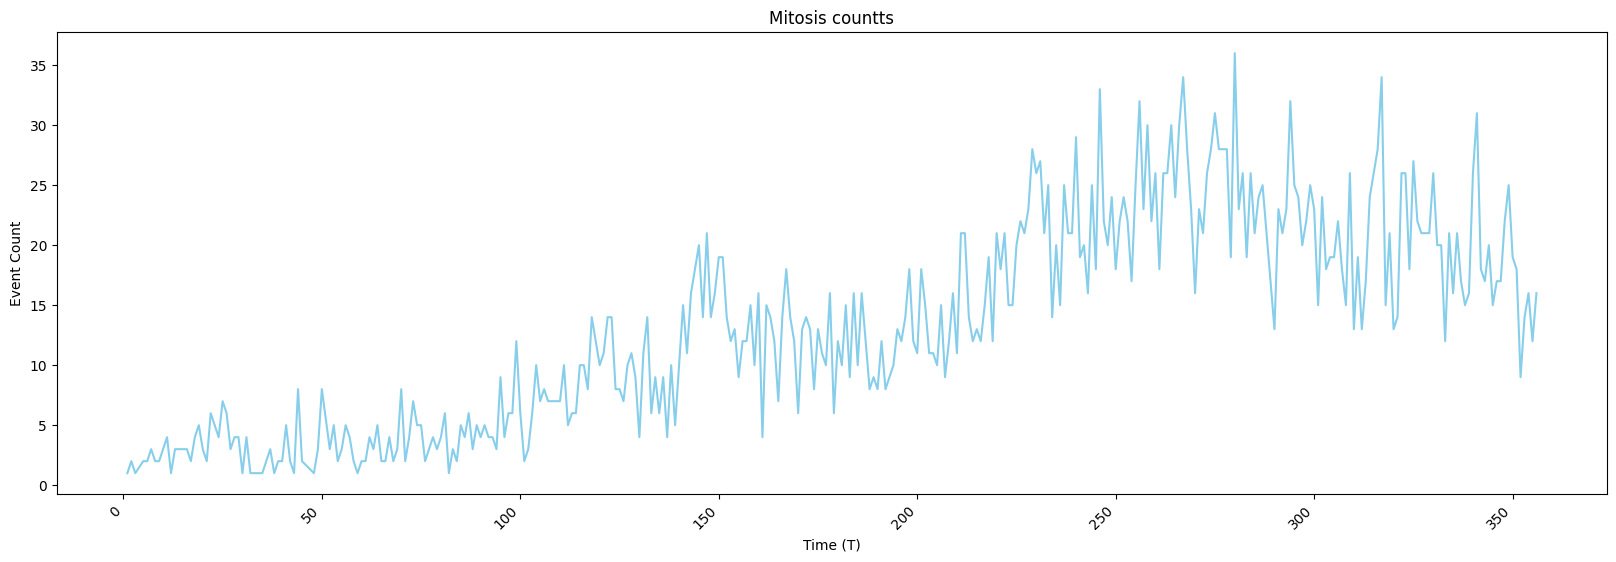

In [5]:
detections = pd.read_csv(oneat_detections, delimiter=',')
cutoff_score = 0.999
min_time = int(min(detections['T']))
max_time = int(max(detections['T']))
filtered_detections = detections[detections['Score'] > cutoff_score]
event_counts = filtered_detections['T'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(20, 6))
event_counts.plot(kind='line', color='skyblue')
event_counts.index = event_counts.index.astype(int)

plt.title(f'Mitosis countts')
plt.xlabel('Time (T)')
plt.ylabel('Event Count')
plt.xticks(rotation=45, ha='right')
fig_name = (
                f"{channel}mitosis_count.png"
            )
plt.savefig(os.path.join(save_dir, fig_name), dpi=300, bbox_inches="tight")
plt.show()

### Plot distributions

In [ ]:
t_max = normalized_global_shape_dynamic_dataframe['t'].max()
time_blocks = []
start = 0
while start < t_max:
    end = min(start + block_size, t_max)
    time_blocks.append((start, end))
    start += overlap

for start, end in time_blocks:
        mitosis_save_path = os.path.join(tracking_directory, f'mitosis_data_start_t_{start}_end_t_{end}/')
        Path(mitosis_save_path).mkdir(parents=True, exist_ok=True) 
        sliced_df = global_shape_dynamic_dataframe[(global_shape_dynamic_dataframe['t'] >= start) & (global_shape_dynamic_dataframe['t'] < end)]
        track_vectors.plot_mitosis_times(sliced_df, save_path = mitosis_save_path)
        print(f'Start time {start}, End time {end}')
        name = f't_start_{start}_t_end_{end}'
        plot_histograms_for_groups(mitosis_save_path, save_dir, dataset_name, channel, name = name)



### Plot distributions at the time of mitosis

In [ ]:
#if plot_at_mitosis_time_distribution:
plot_at_mitosis_time(mitosis_save_path, save_dir, dataset_name, channel)

### Create movie for certain shape and dynamic features 

#### Memory intensive to save all the mp4 files

In [ ]:
columns = ['Radial_Angle_Z','Radial_Angle_Y','Radial_Angle_X','Motion_Angle_Z','Motion_Angle_Y', 'Motion_Angle_X','Cell_Axis_Z','Cell_Axis_Y','Cell_Axis_X' ]


for column in columns:
    gif_filename =  os.path.join(save_dir,f'Shape_Dynamic_movie_{channel}_{column}.mp4')

    frames = []
    for frame in range(int(global_shape_dynamic_dataframe['t'].min()), int(global_shape_dynamic_dataframe['t'].max()) - 1):
        frames.append((global_shape_dynamic_dataframe, column, frame))
    create_video(frames, gif_filename)

### Get Cross correlation between features for zero and n gen tracklets 

In [ ]:
generation_max = global_shape_dynamic_dataframe['Generation ID'].max()
dividing_dataframe = global_shape_dynamic_dataframe[global_shape_dynamic_dataframe["Dividing"] == 1]

sorted_dividing_dataframe = dividing_dataframe.sort_values(by='Track Duration', ascending=False)

unique_trackmate_track_ids = sorted_dividing_dataframe['TrackMate Track ID'].unique()

zero_gen_tracklets = {}
daughter_generations =  {i: {} for i in range(1, generation_max + 1)} 
get_zero_gen_daughter_generations(unique_trackmate_track_ids,global_shape_dynamic_dataframe, zero_gen_tracklets, daughter_generations )


zero_gen_dynamic_polynomials = {}
zero_gen_dynamic_polynomial_coefficients = {}
zero_gen_dynamic_raw = {}
zero_gen_dynamic_autocorrelation = {}
zero_gen_dynamic_crosscorrelation = {}
zero_gen_dynamic_covariance = {}
zero_gen_dynamic_polynomial_time = {}
zero_gen_dynamic_life = []

populate_zero_gen_tracklets(zero_gen_tracklets,global_shape_dynamic_dataframe,zero_gen_dynamic_life,
                              zero_gen_dynamic_polynomial_coefficients,zero_gen_dynamic_polynomials,zero_gen_dynamic_polynomial_time,
                              zero_gen_dynamic_autocorrelation, zero_gen_dynamic_crosscorrelation,zero_gen_dynamic_covariance, zero_gen_dynamic_raw, shape_analysis = False)


zero_gen_shape_polynomials = {}
zero_gen_shape_polynomial_coefficients = {}
zero_gen_shape_raw = {}
zero_gen_shape_autocorrelation = {}
zero_gen_shape_crosscorrelation = {}
zero_gen_shape_covariance = {}
zero_gen_shape_polynomial_time = {}
zero_gen_shape_life = []

populate_zero_gen_tracklets(zero_gen_tracklets,global_shape_dynamic_dataframe,zero_gen_shape_life,
                              zero_gen_shape_polynomial_coefficients,zero_gen_shape_polynomials,zero_gen_shape_polynomial_time,
                              zero_gen_shape_autocorrelation, zero_gen_shape_crosscorrelation,zero_gen_shape_covariance, zero_gen_shape_raw, shape_analysis = True)







N_shape_generation_polynomials = {}
N_shape_generation_polynomial_coefficients = {}
N_shape_generation_raw = {}
N_shape_generation_autocorrelation = {}
N_shape_generation_crosscorrelation = {}
N_shape_generation_covariance = {}
N_shape_generation_polynomial_time = {}
N_shape_generation_life = []


for generation_id in daughter_generations.keys():
    if generation_id >= 1:
        populate_daughter_tracklets(daughter_generations,global_shape_dynamic_dataframe,generation_id,
                       N_shape_generation_life,N_shape_generation_polynomial_coefficients,N_shape_generation_polynomials,
                       N_shape_generation_polynomial_time,N_shape_generation_autocorrelation,
                       N_shape_generation_crosscorrelation, N_shape_generation_covariance, N_shape_generation_raw, shape_analysis = True)
        





N_dynamic_generation_polynomials = {}
N_dynamic_generation_polynomial_coefficients = {}
N_dynamic_generation_raw = {}
N_dynamic_generation_autocorrelation = {}
N_dynamic_generation_crosscorrelation = {}
N_dynamic_generation_covariance = {}
N_dynamic_generation_polynomial_time = {}
N_dynamic_generation_life = []



for generation_id in daughter_generations.keys():
    if generation_id >= 1:
        populate_daughter_tracklets(daughter_generations,global_shape_dynamic_dataframe,generation_id,
                       N_dynamic_generation_life,N_dynamic_generation_polynomial_coefficients,N_dynamic_generation_polynomials,
                       N_dynamic_generation_polynomial_time,N_dynamic_generation_autocorrelation,
                       N_dynamic_generation_crosscorrelation, N_dynamic_generation_covariance, N_dynamic_generation_raw, shape_analysis = False)
   


sigma_dict = {}
for dynamic_feature, list_dynamic_crosscorrelation_functions  in zero_gen_dynamic_crosscorrelation.items():
    
   

    concatenated_crosscorrs = np.concatenate([crosscorr[~np.isnan(crosscorr)] for crosscorr in list_dynamic_crosscorrelation_functions])
    if verbose_generation_plots:
        plt.figure(figsize=(12, 8)) 
        sns.displot(concatenated_crosscorrs, kde=True)
        plt.xlabel('Cross correlation')
        plt.ylabel('Frequency')
        plt.title('Histogram with Gaussian Fit of ' + dynamic_feature)
        plt.show()

    mean, std_dev = norm.fit(concatenated_crosscorrs)
    
    sigma_dict[dynamic_feature] = std_dev
    print('Estimated sigma for {}: {}'.format(dynamic_feature, std_dev))  

plt.figure(figsize=(12, 8)) 
plt.bar(sigma_dict.keys(), sigma_dict.values())
plt.xlabel('Dynamic Feature')
plt.ylabel('Sigma')
plt.title('Gaussian Fits Cross Correlation Zero gen')
plt.tight_layout()
plt.xticks(rotation=45, ha='right') 
fig_name = f"{channel}dynamic_zero_gen_cross_correlation_sigmas.png"
plt.savefig(os.path.join(save_dir, fig_name), dpi=300, bbox_inches='tight')
plt.show()  


sigma_dict = {}
for shape_feature, list_shape_crosscorrelation_functions  in zero_gen_shape_crosscorrelation.items():
    
   

    concatenated_crosscorrs = np.concatenate([crosscorr[~np.isnan(crosscorr)] for crosscorr in list_shape_crosscorrelation_functions])
    if verbose_generation_plots:
        plt.figure(figsize=(12, 8)) 
        sns.displot(concatenated_crosscorrs, kde=True)
        plt.xlabel('Cross correlation')
        plt.ylabel('Frequency')
        plt.title('Histogram with Gaussian Fit of ' + shape_feature)
        plt.show()

    mean, std_dev = norm.fit(concatenated_crosscorrs)
    
    sigma_dict[shape_feature] = std_dev
    print('Estimated sigma for {}: {}'.format(shape_feature, std_dev))  

plt.figure(figsize=(12, 8)) 
plt.bar(sigma_dict.keys(), sigma_dict.values())
plt.xlabel('Shape Feature')
plt.ylabel('Sigma')
plt.title('Gaussian Fits Cross Correlation Zero gen')
plt.tight_layout()
plt.xticks(rotation=45, ha='right') 
fig_name = f"{channel}shape_zero_gen_cross_correlation_sigmas.png"
plt.savefig(os.path.join(save_dir, fig_name), dpi=300, bbox_inches='tight')
plt.show()  

sigma_dict = {}
for dynamic_feature, list_dynamic_crosscorrelation_functions  in N_dynamic_generation_crosscorrelation.items():
    


    concatenated_crosscorrs = np.concatenate([crosscorr[~np.isnan(crosscorr)] for crosscorr in list_dynamic_crosscorrelation_functions])
    if verbose_generation_plots:
        plt.figure(figsize=(12, 8)) 
        sns.displot(concatenated_crosscorrs, kde=True)
        plt.xlabel('Cross correlation')
        plt.ylabel('Frequency')
        plt.title('Histogram with Gaussian Fit of ' + dynamic_feature)
        plt.show()

    mean, std_dev = norm.fit(concatenated_crosscorrs)
    
    sigma_dict[dynamic_feature] = std_dev
    print('Estimated sigma for {}: {}'.format(dynamic_feature, std_dev))  

plt.figure(figsize=(12, 8))     
plt.bar(sigma_dict.keys(), sigma_dict.values())
plt.xlabel('Dynamic Feature')
plt.ylabel('Sigma')
plt.title('Gaussian Fits Cross Correlation N gen')
plt.tight_layout()
plt.xticks(rotation=45, ha='right') 
fig_name = f"{channel}dynamic_N_gen_cross_correlation_sigmas.png"
plt.savefig(os.path.join(save_dir, fig_name), dpi=300, bbox_inches='tight')
plt.show()     


sigma_dict = {}
for shape_feature, list_shape_crosscorrelation_functions  in N_shape_generation_crosscorrelation.items():
    


    concatenated_crosscorrs = np.concatenate([crosscorr[~np.isnan(crosscorr)] for crosscorr in list_shape_crosscorrelation_functions])
    if verbose_generation_plots:
        plt.figure(figsize=(12, 8)) 
        sns.displot(concatenated_crosscorrs, kde=True)
        plt.xlabel('Cross correlation')
        plt.ylabel('Frequency')
        plt.title('Histogram with Gaussian Fit of ' + shape_feature)
        plt.show()

    mean, std_dev = norm.fit(concatenated_crosscorrs)
   
    sigma_dict[shape_feature] = std_dev
    print('Estimated sigma for {}: {}'.format(shape_feature, std_dev))  

plt.figure(figsize=(12, 8))     
plt.bar(sigma_dict.keys(), sigma_dict.values())
plt.xlabel('Shape Feature')
plt.ylabel('Sigma')
plt.title('Gaussian Fits Cross Correlation N gen')
plt.tight_layout()
plt.xticks(rotation=45, ha='right') 
fig_name = f"{channel}shape_N_gen_cross_correlation_sigmas.png"
plt.savefig(os.path.join(save_dir, fig_name), dpi=300, bbox_inches='tight')
plt.show() 
